In [1]:
%matplotlib inline
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from __future__ import division
from collections import Counter
import pandas as pd
import numpy as np
import string
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV

In [2]:
tweets_data_path = 'Tweets.csv'
tweets = pd.read_csv(tweets_data_path, header=0, parse_dates=['tweet_created'])
df = tweets.copy()[['airline_sentiment', 'text']]
tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

Clean tweet text.

In [49]:
# Define functions to process Tweet text and remove stop words
def ProTweets(tweet):
    tweet = re.sub('@\w+', '', tweet)
    tweet = ''.join(c for c in tweet if c not in string.punctuation)
    tweet = re.sub('((www\S+)|(http\S+))', 'urlsite', tweet)
    #tweet = re.sub(r'\d+', 'contnum', tweet)
    tweet = re.sub(' +',' ', tweet)
    tweet = tweet.lower().strip()
    return tweet

def rmStopWords(tweet, stop_words):
    text = tweet.split()
    text = ' '.join(word for word in text if word not in stop_words)
    return text

In [51]:
stop_words = set(stopwords.words('english'))
pro_tweets = []
for tweet in df['text']:
    processed = ProTweets(tweet)
    pro_stopw = rmStopWords(processed, stop_words)
    pro_tweets.append(pro_stopw)
    
df['pro_text'] = pro_tweets

Encode airline sentiment and get train and test sets.

In [52]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['airline_sentiment_encoded'] = le.fit_transform(df.airline_sentiment.values)

X = df.drop('airline_sentiment_encoded', axis=1)
y = df[['airline_sentiment_encoded', 'airline_sentiment']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.33, random_state=0)

A pipeline to create a bag of words representation of the tweets, then fit a multinomial NB classifier and tune some hyperparamters.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

params = {
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__min_df': [0, 0.000001, 0.00001,0.0001],
    'clf__alpha': [0, 0.01, 0.1, 1, 10, 100]
}


def runPipeLine(X_train, y_train, params):
    
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB()),
    ])

    grid_search = GridSearchCV(pipeline, params, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search
gs = runPipeLine(X_train.pro_text.values, y_train.airline_sentiment_encoded.values, params=params)

Best score: 0.761
Best parameters set:
	clf__alpha: 0.1
	vect__min_df: 0
	vect__ngram_range: (1, 2)


See how the best estimator performs on the test set.

In [54]:
vect = gs.best_estimator_.named_steps['vect']
clf = gs.best_estimator_.named_steps['clf']
test_bag = vect.transform(X_test.pro_text.values)
print("Accuracy on test set {:.4f}".format(clf.score(test_bag, y_test.airline_sentiment_encoded.values.reshape(-1,1))))


Accuracy on test set 0.7697


Which words does our classifier most strongly associate with negative and positive tweets?

In [78]:
words = pd.Series(gs.best_estimator_.named_steps['vect'].get_feature_names())
neg_coef = gs.best_estimator_.named_steps['clf'].coef_[0]
pos_coef = gs.best_estimator_.named_steps['clf'].coef_[2]
neg_ind_to_sort = np.argsort(neg_coef)
pos_ind_to_sort = np.argsort(pos_coef)
neg_words = words.iloc[neg_ind_to_sort[-25:][::-1]]
pos_words = words.iloc[pos_ind_to_sort[-25:][::-1]]

In [79]:
neg_words

24533                 flight
28547                    get
12419              cancelled
55752                service
33255                  hours
31672                   help
32298                   hold
17067               customer
62913                   time
34232                     im
48395                  plane
58955                  still
6249                     amp
66779                     us
12508                   cant
18303                delayed
12004                   call
17107       customer service
33100                   hour
25926              flightled
12436    cancelled flightled
66711                urlsite
45550                    one
9076                     bag
20242                   dont
dtype: object

In [80]:
pos_words

61610              thanks
61421               thank
24533              flight
66711             urlsite
30243               great
55752             service
39670                love
43002                much
17067            customer
30704                guys
28547                 get
10057                best
29808                good
29962                 got
17107    customer service
62913                time
8579              awesome
63443               today
34232                  im
66779                  us
5072              airline
6105              amazing
26902              flying
31672                help
6249                  amp
dtype: object

Examine our mistakes.

In [88]:
preds = gs.best_estimator_.predict(X_test.pro_text.values)
missed_indices = preds != y_test.airline_sentiment_encoded.values
missed_preds = pd.Series(preds[missed_indices])
missed_df = X_test.iloc[missed_indices,:]
missed_df['predicted_sentiment'] = missed_preds.values
missed_df['predicted_sentiment'] = le.inverse_transform(missed_df.predicted_sentiment)

C:\Users\lid92al\WinPython-64bit-3.4.4.2\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lid92al\WinPython-64bit-3.4.4.2\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


As shown below, our classifier struggled the most with neutral tweets.

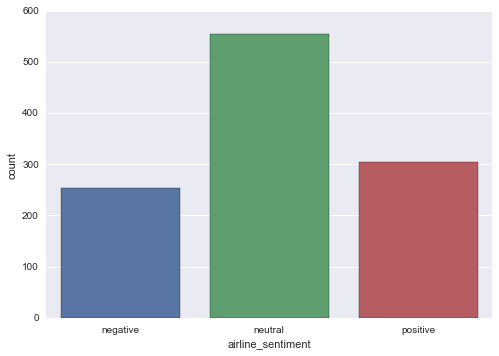

In [89]:
sns.countplot(data=missed_df, x='airline_sentiment',  order=['negative', 'neutral', 'positive'])

The majority of our mistakes were classifying non-negative tweets as negative.

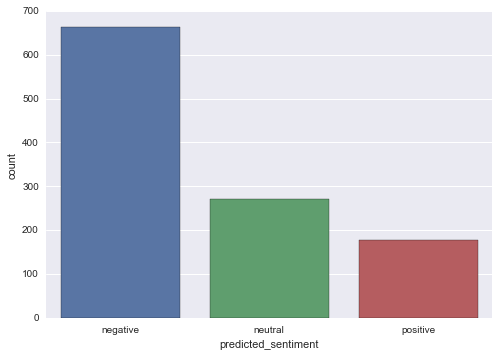

In [90]:
sns.countplot(data=missed_df, x='predicted_sentiment' , order=['negative', 'neutral', 'positive'])

We often classified neutral tweets as negative, as can be seen by the increased density of points in that region below.

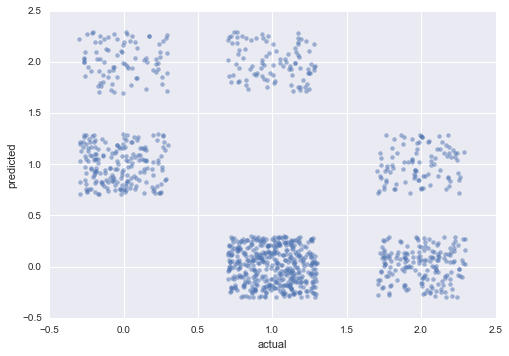

In [40]:
sns.regplot(x="actual", y="predicted", data=missed_df, fit_reg=False, x_jitter= 0.3, y_jitter=0.3,  scatter_kws={'alpha': 0.5})